In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import os
from PIL import Image
from numpy import asarray
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Conv2DTranspose, concatenate, Flatten
from tensorflow.keras import Input
from tensorflow.keras import layers, Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [8]:
image = Image.open('../data/ground truth/0060c0a5_agbm.tif')
 
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

TIFF
(256, 256)
F


In [9]:
from numpy import asarray
 
# asarray() class is used to convert
# PIL images into NumPy arrays
numpydata = asarray(image)
 
# <class 'numpy.ndarray'>
print(type(numpydata))
 
#  shape
print(numpydata.shape)

<class 'numpy.ndarray'>
(256, 256)


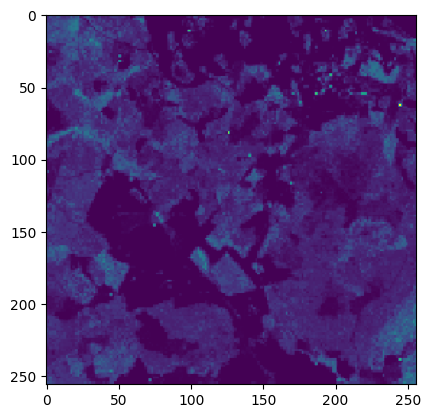

In [10]:
plt.imshow(numpydata)

In [11]:
numpydata = numpydata[np.newaxis,  :, :]

In [12]:
"""
input 1 = s1
input 2 = s2


now it's time to seperate s1 and s2 images!
"""

"\ninput 1 = s1\ninput 2 = s2\n\n\nnow it's time to seperate s1 and s2 images!\n"

In [13]:
def get_X(sat_type='s1'):                                 #gets X from both satellites, depending on value for
    X = []                                                #sat_type variable. Also normalizes the images instantly. 
    basepath1 =  '../data/train data/s1'                  #Have to make one for target/ground truth
    basepath2 =  '../data/train data/s2'
    scaler = MinMaxScaler()
    if sat_type=='s1':
        for file in os.listdir(basepath1):
            path = os.path.join(basepath1, file)
            img = tifffile.imread(path)
            img = tf.image.per_image_standardization(img)
            img = tf.expand_dims(img,axis=0)
            X.append(img)
    elif sat_type=='s2':
        for file in os.listdir(basepath2):
            path = os.path.join(basepath2, file)
            img = tifffile.imread(path)
            img = tf.image.per_image_standardization(img)
            img = tf.expand_dims(img,axis=0)
            X.append(img)
    else:
        print("Are you high or something? This isn't that hard.")
    return np.asarray(X)

In [14]:
X_s1 = get_X()

Metal device set to: Apple M1 Pro


2022-12-01 13:08:33.755481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 13:08:33.755946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
X_s1.shape

(12, 1, 256, 256, 4)

In [16]:
X_s2 = get_X(sat_type='s2')

In [17]:
X_s2.shape

(12, 1, 256, 256, 11)

In [18]:
___ = get_X('lol')

Are you high or something? This isn't that hard.


In [19]:
X_s1 == X_s2

/var/folders/8g/1wnh9tg11rv0m3y6wdt66jvw0000gn/T/ipykernel_32558/1518868066.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  X_s1 == X_s2


False

In [20]:
len(X_s2)

12

In [21]:
def init_model(start_n):
    
    input1 = Input(shape=(256,256,4))
    input2 = Input(shape=(256,256,11))

    conv1 = Conv2D(start_n * 1, (4, 4), activation="relu", padding="same")(input1)
    conv1_1 = Conv2D(start_n * 1, (4, 4), activation="relu", padding="same")(input2)
    conv1 = concatenate([conv1, conv1_1])
    conv1 = Conv2D(start_n * 1, (4, 4), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_n * 2, (4, 4), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_n * 2, (4, 4), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_n * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_n * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_n * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_n * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    
    convm = Conv2D(start_n * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_n * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_n * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_n * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_n * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_n * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_n * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_n * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_n * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_n * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_n * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_n * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_n * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_n * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="linear")(uconv1)

    model = Model(inputs=[input1, input2], outputs = [output_layer])
    
    model.compile(loss='mse',
                  optimizer='rmsprop',
                  metrics=['mse'])

    return model

In [22]:
def fit_model(model,X1, X2, y):
    for x in range(0,10):
        history = model.fit([X1[x],X2[x]], y, verbose = 1, epochs = 5)
    return model, history

In [23]:
model = init_model(32)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  2080        ['input_1[0][0]']                
                                )                                                             

                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 12  0           ['conv2d_transpose_2[0][0]',     
                                8)                                'conv2d_4[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 128, 128, 12  0           ['concatenate_3[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 64  73792       ['dropout_6[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_16

In [25]:
model, history = fit_model(model, X_s1,X_s2, numpydata)

Epoch 1/5


2022-12-01 13:08:51.059865: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-01 13:08:52.207613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step - loss: 11158.5488 - mse: 11158.5488
Epoch 2/5
1/1 [==============================] - 0s 233ms/step - loss: 9450.0938 - mse: 9450.0938
Epoch 3/5
1/1 [==============================] - 0s 92ms/step - loss: 11137.6689 - mse: 11137.6689
Epoch 4/5
1/1 [==============================] - 0s 129ms/step - loss: 11110.2832 - mse: 11110.2832
Epoch 5/5
1/1 [==============================] - 0s 93ms/step - loss: 11073.1367 - mse: 11073.1367
Epoch 1/5
1/1 [==============================] - 0s 93ms/step - loss: 11013.9619 - mse: 11013.9619
Epoch 2/5
1/1 [==============================] - 0s 91ms/step - loss: 10914.9707 - mse: 10914.9707
Epoch 3/5
1/1 [==============================] - 0s 91ms/step - loss: 10731.6709 - mse: 10731.6709
Epoch 4/5
1/1 [==============================] - 0s 91ms/step - loss: 10399.5723 - mse: 10399.5723
Epoch 5/5
1/1 [==============================] - 0s 91ms/step - loss: 9748.5098 - mse: 9748.5098
Epoch 1/5
1/1 [=========

In [26]:
prediction = model.predict([X_s1[11],X_s2[11]])

1/1 [==============================] - 0s 217ms/step


2022-12-01 13:09:03.524475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


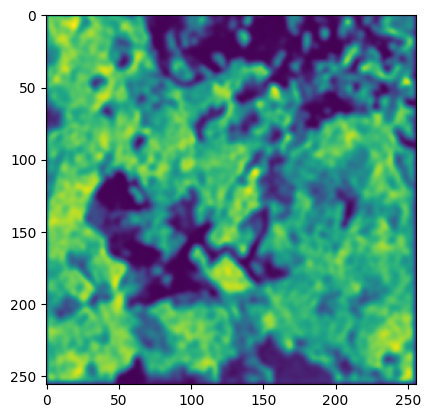

In [28]:
predict_ = tf.squeeze(prediction)
plt.imshow(predict_)

In [29]:
#On a larger dataset, this should go pretty well! Our mse is decreasing everytime, all we need is enough images!

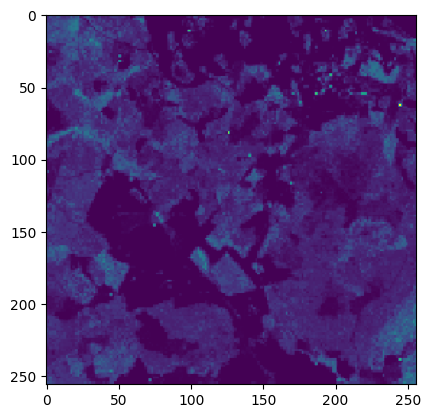

In [31]:
numpydata = tf.squeeze(numpydata)
plt.imshow(numpydata)